Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.077296 s


'compile' took 0.669535 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.47e-02, 4.48e+03, 4.48e-06]    [3.42e-02, 4.48e+03, 4.48e-06]    []  
1000      [3.53e+01, 3.28e+03, 1.03e+02]    [3.33e+01, 3.28e+03, 1.03e+02]    []  
2000      [8.48e+00, 2.77e+03, 5.67e+01]    [4.99e+00, 2.77e+03, 5.67e+01]    []  
3000      [8.09e+00, 2.35e+03, 2.81e+01]    [5.33e+00, 2.35e+03, 2.81e+01]    []  
4000      [1.24e+01, 2.00e+03, 2.03e+01]    [5.53e+00, 2.00e+03, 2.03e+01]    []  
5000      [8.74e+00, 1.66e+03, 1.88e+01]    [6.40e+00, 1.66e+03, 1.88e+01]    []  
6000      [9.20e+00, 1.38e+03, 1.80e+01]    [7.77e+00, 1.38e+03, 1.80e+01]    []  
7000      [8.26e+00, 1.13e+03, 1.75e+01]    [9.13e+00, 1.13e+03, 1.75e+01]    []  
8000      [1.91e+01, 9.18e+02

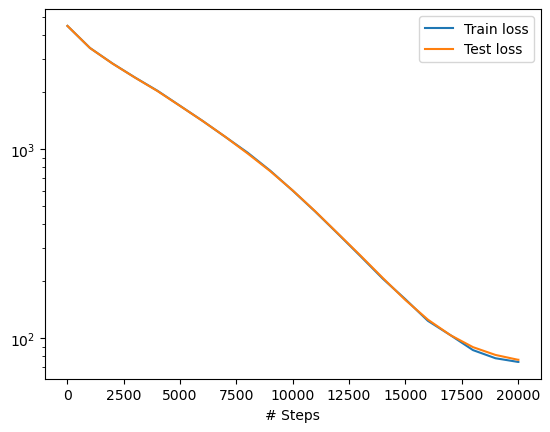

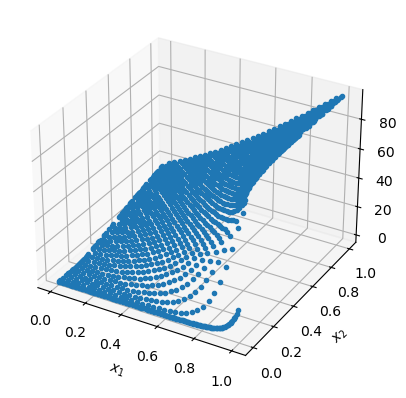

In [1]:
#PINN Case 1 for 1D Diffusion Case
import numpy as np
import os
#os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'     #Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle
import deepxde as dde
#Normalise the parameter 
D = 3.8e-1  #mm^2/s      #Original was 3.8e-11 mm^2/s
l = 1       #mm          #Original was 50 mm
t = 1       #s           #Original was 6.5e7 s

#Define the domain
geom = dde.geometry.Interval(0, l)                          #1D Length
timedomain = dde.geometry.TimeDomain(0, t)                  #Time Domain
geomtime = dde.geometry.GeometryXTime(geom, timedomain)     #Combination of Geometry and Time

#PDE Definition (The derived and simplified equation in reposrt section5.2.1)
#Gradient arguments definition follows:
#   Arguments for dy/dx are set as (y,x) where the later two arguments indicates which y and which x in the whole data
#   For example, if there are two outputs (o1,o2) and two inputs (i1,i2), d(o1)/d(i2) is defined as (y,x,0,1) where 0 
#   is the first of output indicating o1 and 1 indicating second of inputs. 
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)    #Jacobian is frst order PDE 
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)    #Hessian is second order PDE
    return dy_t- D*dy_xx                        #Return of equilibrium in equal to zero form (x=y => x-y=0)

#Boundary conditions and Initial conditions
#BC and IC arguments are defined as (applied geometry and time domain, which variable and its constraint, applid variables, applied locations)
#For examples:
#If there is (geomtime, lambda x: (x[:, 0:1]) * 100, lambda _, on_boundary: on_boundary), it means
#(geomtime, lambda x: (x[:, 0:1]) * 100)=>  At the defined geometry and time domain, set the x in all row but the first column (indicating x here) to have value of 100
#(lambda _, on_boundary: on_boundary)=>     And applied on all variables where they are at the boundary of the domain (it sets not all x but only when x is locating at the edge)
bc = dde.icbc.DirichletBC(geomtime, lambda x: (x[:, 0:1]) * 100, lambda _, on_boundary: on_boundary)     #Dirichlet is time independent
ic = dde.icbc.IC(geomtime, lambda x: 0, lambda _, on_initial: on_initial)                                #Initial set to 0 on variables when time is 0 (on initial)

#Data compile
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc,ic],
    num_domain=1000,    #Residual Points Sampling in the domain
    num_boundary=150,   #Residual Points Sampling at the boundary
    num_initial=180,    #Residual Points Sampling at initial
    num_test=1000,      #Residual Points Sampling during test (This will select another set of residual points other than training ones to compute the loss)
)

#Network Structure
layer_size = [2] + [64] * 5 + [1] #Two inputs (x,t) and one output (y)
activation ="tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

#Model compile
model = dde.Model(data, net)
model.compile("adam", lr=1e-4)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)



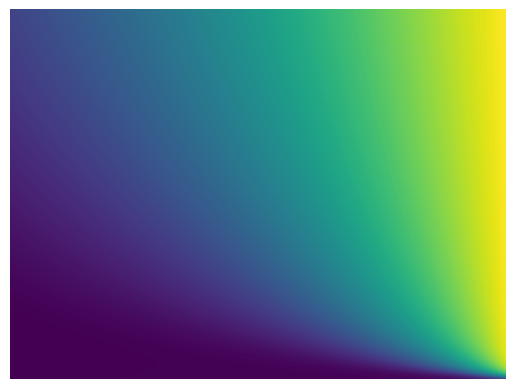

SSIM: 0.9143366394051181


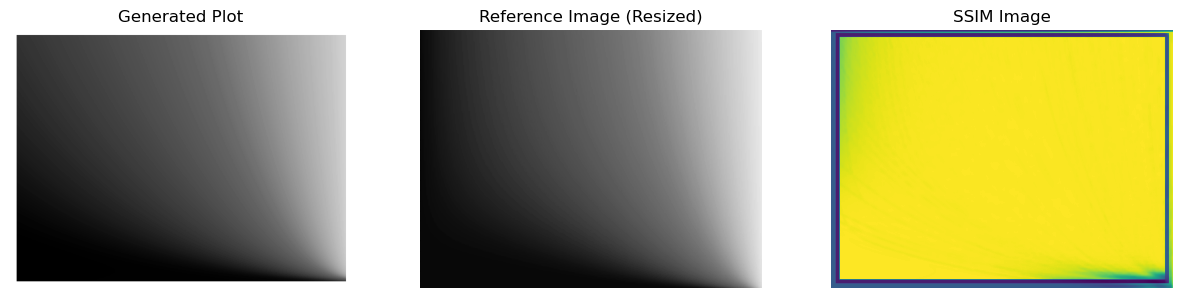

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim
from PIL import Image

# Create a grid of points to evaluate the solution
x = np.linspace(0, 1, 2000)
t = np.linspace(0, 1, 2000)
X, T = np.meshgrid(x, t)
points = np.vstack([X.ravel(), T.ravel()]).T

# Predict the solution at these grid points
y_pred = model.predict(points).reshape(X.shape)

# Plot the solution and save it as an image file
fig, ax = plt.subplots()
cax = ax.imshow(y_pred, extent=(x.min(), x.max(), t.min(), t.max()), aspect='auto', cmap='viridis', origin='lower')
ax.axis('off')
plt.savefig('generated_plot.png', bbox_inches='tight')
plt.show()

# Load the saved plot and the reference image
generated_image = Image.open('generated_plot.png').convert('L')
reference_image = Image.open('Solution.png').convert('L') 

# Resize the reference image to match the dimensions of the generated image
reference_image_resized = reference_image.resize(generated_image.size)

# Convert images to numpy arrays
generated_image_np = np.array(generated_image)
reference_image_resized_np = np.array(reference_image_resized)

# Convert images to float representation
generated_image_float = img_as_float(generated_image_np)
reference_image_resized_float = img_as_float(reference_image_resized_np)

# Compare the images using SSIM
ssim_index, ssim_image = ssim(generated_image_float, reference_image_resized_float, data_range=generated_image_float.max() - generated_image_float.min(), full=True)

# Display the SSIM index
print(f"SSIM: {ssim_index}")

# Display the images and the SSIM image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(generated_image_float, cmap=plt.cm.gray)
ax[0].set_title('Generated Plot')

ax[1].imshow(reference_image_resized_float, cmap=plt.cm.gray)
ax[1].set_title('Reference Image (Resized)')

ax[2].imshow(ssim_image, cmap='viridis')
ax[2].set_title('SSIM Image')

for a in ax:
    a.axis('off')

plt.show()
